In [1]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from IPython.display import SVG, display, HTML
style = "<style>svg{width: 100% !important; height: 100% !important;} </style>"
HTML(style)
from sklearn.ensemble import RandomForestClassifier
from chess_lib import create_df_from_pgn, statistics_eco, create_X, create_series_y, plot_auc_roc, fit_model
from sklearn.linear_model import LogisticRegression
from itertools import combinations

In [2]:
path_to_train_file = 'C:\python\ML_coursera\Data Science\lichess_base\lichess_shahmatpatblog_2021-01-07.pgn'
path_to_test_file = 'C:\python\ML_coursera\Data Science\lichess_base\lichess_shahmatpatblog_2021-02-25.pgn'
feature_names = ['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'TimeControl', 'ECO']
raw_train_data = create_df_from_pgn(path_to_train_file, feature_names)
raw_test_data = create_df_from_pgn(path_to_test_file, feature_names)

In [4]:
X_train_big = create_X(raw_train_data, raw_test_data, for_test=False)
X_test_big = create_X(raw_train_data, raw_test_data, for_test=True)
X_train_big.head()

,Date_Time,date_,my_result,my_color,elo_diff,event,time_control,day_of_week,hour_of_game,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games,my_rating,ECO_games,ECO_win_rate
0,2021-01-06 17:50:54,2021-01-06,0,0,-2,0,1,3,17,63.0,29.0,0.46,9,5,0.556,2239,24,0.458
1,2021-01-06 17:40:56,2021-01-06,0,1,-2,0,1,3,17,63.0,29.0,0.46,8,5,0.625,2239,35,0.457
2,2021-01-06 17:38:52,2021-01-06,0,0,10,0,1,3,17,63.0,29.0,0.46,7,5,0.714,2245,23,0.478
3,2021-01-06 17:32:01,2021-01-06,0,1,22,0,1,3,17,63.0,29.0,0.46,6,5,0.833,2251,5,0.200
4,2021-01-06 12:37:40,2021-01-06,0,0,46,0,1,3,12,63.0,29.0,0.46,5,5,1.000,2258,22,0.409


### Scatter plot (for viewing how my result depends of my current rating and rating difference)

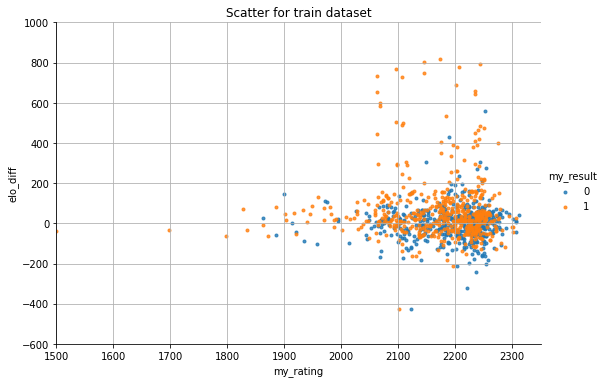

In [98]:
ax = sns.lmplot(x='my_rating', y='elo_diff', data=X_train_big, hue='my_result', fit_reg=False, markers='.', aspect=1.5)
plt.title('Scatter for train dataset')
plt.grid()
plt.xlim([1500, 2350])
plt.ylim([-600, 1000]);

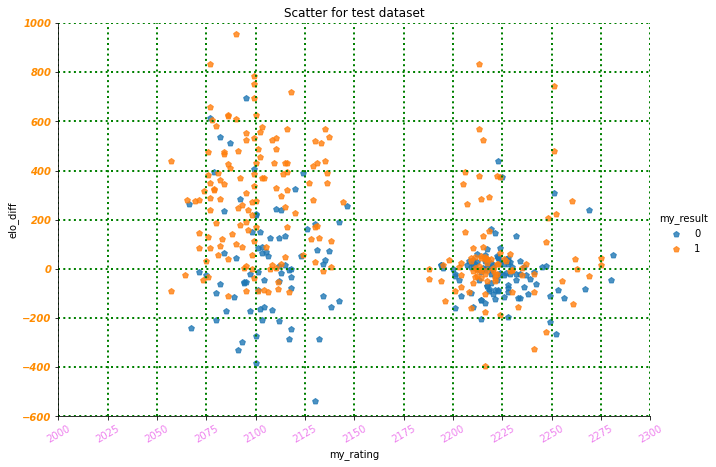

In [99]:
ax = sns.lmplot(x='my_rating', y='elo_diff', data=X_test_big, hue='my_result', fit_reg=False, height=6, markers='p',
               aspect=1.5)
plt.title('Scatter for test dataset')
plt.grid(color='green', linestyle=':', linewidth=2)
#plt.legend(loc='center')
plt.xticks(ticks=range(2000, 2301, 25), rotation=30, color='violet')
plt.yticks(color='darkorange', fontstyle='oblique', fontweight='bold')
plt.xlim([2000, 2300])
plt.ylim([-600, 1000])
plt.plot();

### Bar plot (mean result for colors of my games)

In [154]:
a = X_train_big.groupby('my_color').agg({'my_result': 'mean'}).reset_index()
a.my_result = a.my_result * 100
a = a.rename(columns={'my_result': 'percent_of_wins'})
a

,my_color,percent_of_wins
0,0,50.096339
1,1,52.895753


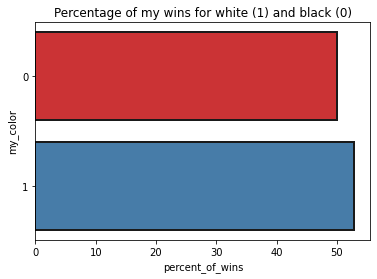

In [204]:
sns.barplot(x=a.percent_of_wins, y=a.my_color, palette='Set1', orient='h', linewidth=2, edgecolor='.1')
plt.title('Percentage of my wins for white (1) and black (0)')
plt.plot();

### Hystogram (amount of games per hours of day)

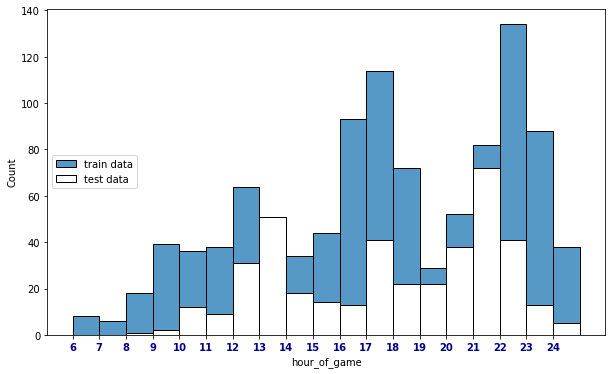

In [187]:
plt.figure(figsize=(10, 6))
sns.histplot(data=X_train_big.hour_of_game + 4, bins=19)
sns.histplot(data=X_test_big.hour_of_game + 4, bins=17, facecolor='white')
plt.xticks(ticks=range(25), rotation=0, color='darkblue', fontweight='semibold')
plt.legend(('train data', 'test data'), loc='center left')
plt.plot();

### Hystogram (my winned and lost games per hours)

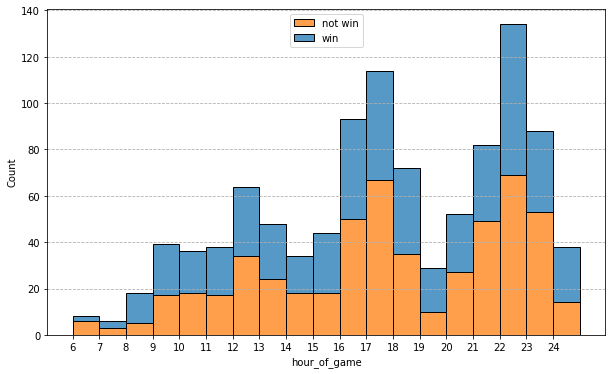

In [231]:
plt.figure(figsize=(10, 6))
sns.histplot(data=X_train_big, x=X_train_big.hour_of_game + 4, hue='my_result', bins=19, multiple='stack') #dodge раздел столбцы
plt.xticks(ticks=range(25))
plt.legend(('not win', 'win'), loc='upper center')
plt.grid(axis='y', linestyle='--')
plt.plot();

### Hystogram (my winned and lost games per days of week)

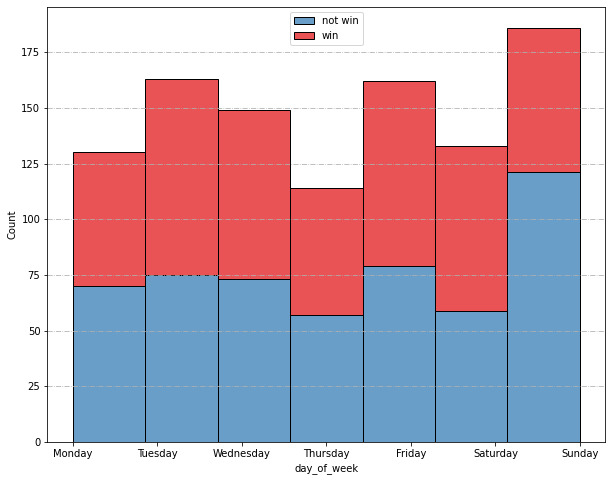

In [232]:
plt.figure(figsize=(10, 8))
sns.histplot(data=X_train_big, x=X_train_big.day_of_week, hue='my_result', bins=7, multiple='stack', palette='Set1')
plt.xticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend(('not win', 'win'), loc='upper center')
plt.grid(axis='y', linestyle='-.')
plt.plot();

#### OMG! I should not play chess on sundays!

### Kernel estimate density plot for elo difference feature

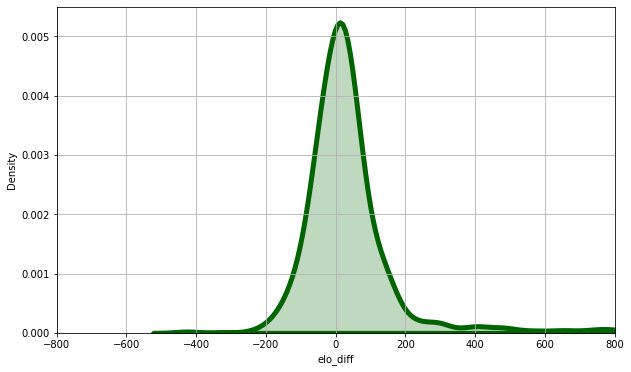

In [252]:
plt.figure(figsize=(10, 6))
sns.kdeplot(X_train_big.elo_diff, lw=5, color='darkgreen', fill=True)
plt.xticks(ticks=range(-800, 801, 200))
plt.xlim([-800, 800])
plt.grid(linestyle='-')
plt.plot();

### Heatmap of correlation between features

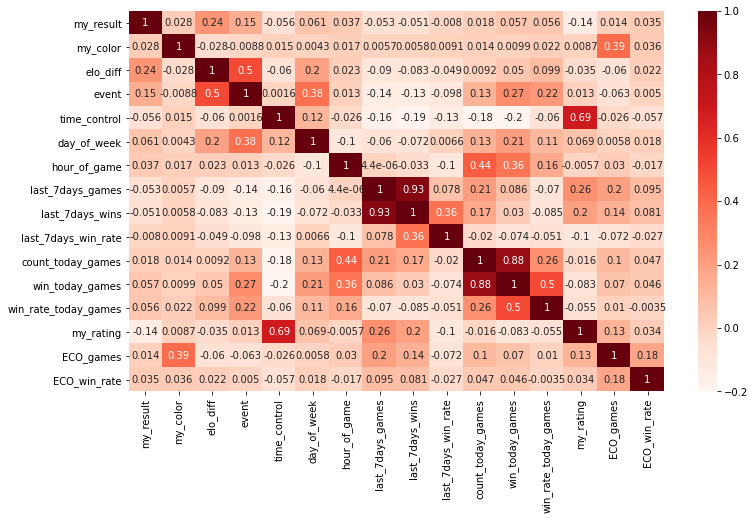

In [257]:
plt.figure(figsize=(12, 7))
sns.heatmap(X_train_big.corr(), annot=True, cmap=plt.cm.Reds);

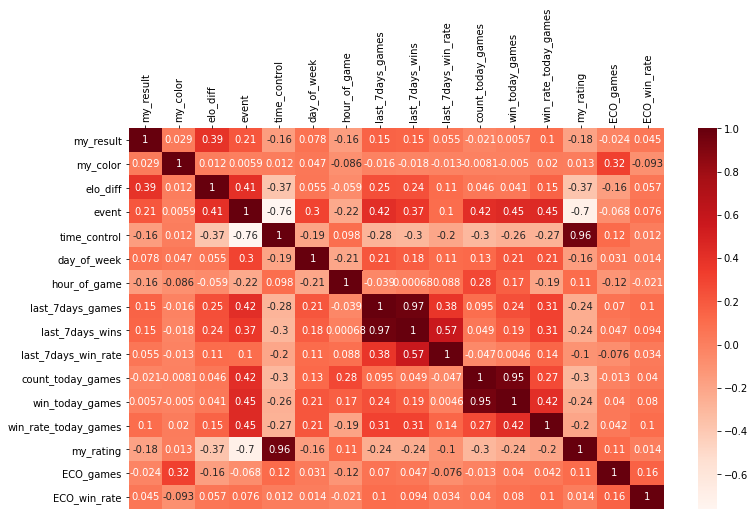

In [261]:
plt.figure(figsize=(12, 7))
g = sns.heatmap(X_test_big.corr(), annot=True, cmap=plt.cm.Reds)
g.xaxis.set_ticks_position('top')
g.xaxis.set_tick_params(rotation=90);

### Dynamics of my rating

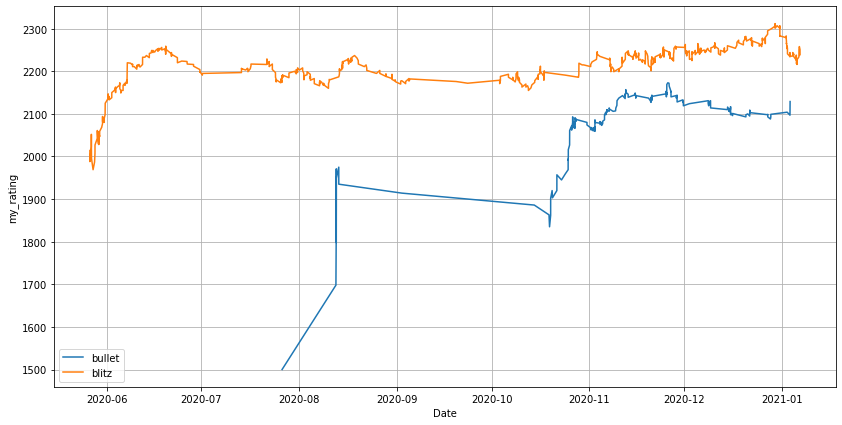

In [278]:
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x=X_train_big.Date_Time, y=X_train_big.my_rating, hue=X_train_big.time_control)
ax.xaxis.set_label_text('Date')
plt.legend(('bullet', 'blitz'), loc='lower left')
plt.grid()